In [1]:
#loading necessary packages
import arch
import holidays
from datetime import datetime
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader as dr
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from datetime import datetime
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols

%matplotlib inline

In [2]:
#dataimport
gold_df=pd.read_excel('./final data.xlsx',sheet_name='GOLD')
equity_df=pd.read_excel('./final data.xlsx',sheet_name='EQTY ETF')
start = datetime(2019, 10, 1)
end = datetime(2019, 11, 30)
syms = ['DGS30','DGS10','DGS7', 'DGS5','DGS3', 'DGS2'] 
treasury_yield_df=dr(syms, 'fred',start,end)


In [3]:
#Setting date as index in datetime format
#date alignment preprocessing was done in excel file itself
gold_df["Date"] = pd.to_datetime(gold_df["Date"], format="%d/%m/%Y")
gold_df.set_index("Date", inplace=True)
equity_df["Date"] = pd.to_datetime(equity_df["Date"], format="%d/%m/%Y")
equity_df.set_index("Date", inplace=True)


In [4]:
gold_df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-09-30  139.770004  140.210007  138.029999  138.869995  138.869995   
2019-10-01  138.070007  140.190002  137.800003  139.630005  139.630005   
2019-10-02  140.789993  141.880005  140.460007  141.259995  141.259995   
2019-10-03  141.360001  143.250000  141.289993  141.899994  141.899994   
2019-10-04  141.479996  142.309998  141.139999  141.899994  141.899994   

              Volume  
Date                  
2019-09-30  15459100  
2019-10-01  12476200  
2019-10-02  11914300  
2019-10-03  12396100  
2019-10-04   9651000

In [5]:
gold_df=gold_df[gold_df.index!=datetime(2019,9,30)]

In [6]:
gold_df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-10-01  138.070007  140.190002  137.800003  139.630005  139.630005   
2019-10-02  140.789993  141.880005  140.460007  141.259995  141.259995   
2019-10-03  141.360001  143.250000  141.289993  141.899994  141.899994   
2019-10-04  141.479996  142.309998  141.139999  141.899994  141.899994   
2019-10-07  141.160004  141.770004  140.240005  140.690002  140.690002   

              Volume  
Date                  
2019-10-01  12476200  
2019-10-02  11914300  
2019-10-03  12396100  
2019-10-04   9651000  
2019-10-07   6127200

In [7]:
treasury_yield_df.tail()

DGS30  DGS10  DGS7  DGS5  DGS3  DGS2
DATE                                            
2019-11-25   2.21   1.76  1.71  1.62  1.60  1.61
2019-11-26   2.18   1.74  1.68  1.58  1.58  1.58
2019-11-27   2.19   1.77  1.71  1.63  1.61  1.63
2019-11-28    NaN    NaN   NaN   NaN   NaN   NaN
2019-11-29   2.21   1.78  1.73  1.62  1.61  1.61

In [8]:
#to deal with Null values
treasury_yield_df.dropna(axis=0,inplace=True)
treasury_yield_df.tail()

DGS30  DGS10  DGS7  DGS5  DGS3  DGS2
DATE                                            
2019-11-22   2.22   1.77  1.71  1.62  1.60  1.61
2019-11-25   2.21   1.76  1.71  1.62  1.60  1.61
2019-11-26   2.18   1.74  1.68  1.58  1.58  1.58
2019-11-27   2.19   1.77  1.71  1.63  1.61  1.63
2019-11-29   2.21   1.78  1.73  1.62  1.61  1.61

In [9]:
equity_df=equity_df[equity_df.index!=datetime(2019,9,30)]

In [10]:
gold_df.shape

(43, 6)

In [11]:
equity_df.shape

(43, 6)

In [12]:
treasury_yield_df.shape

(41, 6)

# 2.Data Processing


In [13]:
gold_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [14]:
gold_df["Daily Return"] = gold_df[gold_df.columns[-2]].pct_change(1)
gold_df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-10-01  138.070007  140.190002  137.800003  139.630005  139.630005   
2019-10-02  140.789993  141.880005  140.460007  141.259995  141.259995   
2019-10-03  141.360001  143.250000  141.289993  141.899994  141.899994   
2019-10-04  141.479996  142.309998  141.139999  141.899994  141.899994   
2019-10-07  141.160004  141.770004  140.240005  140.690002  140.690002   

              Volume  Daily Return  
Date                                
2019-10-01  12476200           NaN  
2019-10-02  11914300      0.011674  
2019-10-03  12396100      0.004531  
2019-10-04   9651000      0.000000  
2019-10-07   6127200     -0.008527

In [15]:
equity_df["Daily Return"] = equity_df[equity_df.columns[-2]].pct_change(1)
equity_df.head()

Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2019-10-01  33.160000  33.160000  32.860001  32.939999  31.385347   67800   
2019-10-02  32.389999  32.389999  32.049999  32.099998  30.584991   51900   
2019-10-03  32.090000  32.299999  31.950001  32.299999  30.775549   55600   
2019-10-04  32.340000  32.580002  32.340000  32.580002  31.042341   21900   
2019-10-07  32.560001  32.750000  32.560001  32.630001  31.089977    7000   

            Daily Return  
Date                      
2019-10-01           NaN  
2019-10-02     -0.025501  
2019-10-03      0.006230  
2019-10-04      0.008669  
2019-10-07      0.001535

# 3.Data Summaries

In [16]:
#treasury
oct_t_df=treasury_yield_df.loc[:datetime(2019,10,31)]
oct_t_avg=np.mean(oct_t_df)
print("Average Oct yield is \n{}".format(oct_t_avg))
nov_t_df=treasury_yield_df.loc[datetime(2019,11,1):]
nov_t_avg=np.mean(nov_t_df)
print("Average Nov yield is \n{}".format(nov_t_avg))


Average Oct yield is 
DGS30    2.190455
DGS10    1.706818
DGS7     1.615000
DGS5     1.525000
DGS3     1.528182
DGS2     1.551364
dtype: float64
Average Nov yield is 
DGS30    2.280526
DGS10    1.812105
DGS7     1.735789
DGS5     1.639474
DGS3     1.612105
DGS2     1.612632
dtype: float64


In [17]:
st_dev_Oct = np.std(oct_t_df)
st_dev_NoV = np.std(nov_t_df)
print("Standard Deviation for October Yield is \n{}\n".format(st_dev_Oct))
print("Standard Deviation for November Yield is \n{}".format(st_dev_NoV))

Standard Deviation for October Yield is 
DGS30    0.098971
DGS10    0.102398
DGS7     0.098338
DGS5     0.102058
DGS3     0.094226
DGS2     0.078468
dtype: float64

Standard Deviation for November Yield is 
DGS30    0.074866
DGS10    0.063294
DGS7     0.059411
DGS5     0.051347
DGS3     0.042868
DGS2     0.032902
dtype: float64


In [18]:
#gold
oct_g_avg=gold_df.loc[:datetime(2019,11,1),gold_df.columns[-3]].mean()
print("Average Oct Price for Gold is \n{}".format(oct_g_avg))
oct_g_sd=gold_df.loc[:datetime(2019,11,1),gold_df.columns[-3]].std()
print("Standard deviation of Oct Price for Gold is \n{}".format(oct_g_sd))
nov_g_avg=gold_df.loc[datetime(2019,11,1):,gold_df.columns[-3]].mean()
print("Average Nov Price for Gold is \n{}".format(nov_g_avg))
nov_g_sd=gold_df.loc[datetime(2019,11,1):,gold_df.columns[-3]].std()
print("Standard deviation of Nov Price for Gold is \n{}".format(nov_g_sd))


Average Oct Price for Gold is 
140.94499906666667
Standard deviation of Oct Price for Gold is 
0.8827414766643555
Average Nov Price for Gold is 
138.57049941999998
Standard deviation of Nov Price for Gold is 
1.5620945764545295


In [19]:
#Eqty ETF
oct_e_avg=equity_df.loc[:datetime(2019,11,1),equity_df.columns[-3]].mean()
print("Average Oct Price for Equity ETF is \n{}".format(oct_e_avg))
oct_e_sd=equity_df.loc[:datetime(2019,11,1),equity_df.columns[-3]].std()
print("Standard deviation of Oct Price for Equity ETF is \n{}".format(oct_g_sd))
nov_e_avg=equity_df.loc[datetime(2019,11,1):,equity_df.columns[-3]].mean()
print("Average Nov Price for Equity ETF is \n{}".format(nov_e_avg))
nov_e_sd=equity_df.loc[datetime(2019,11,1):,equity_df.columns[-3]].std()
print("Standard deviation of Nov Price for Equity ETF is \n{}".format(nov_e_sd))


Average Oct Price for Equity ETF is 
31.996331930000007
Standard deviation of Oct Price for Equity ETF is 
0.8827414766643555
Average Nov Price for Equity ETF is 
33.2652296065
Standard deviation of Nov Price for Equity ETF is 
0.14621128047678067


In [20]:
gold_df["High minus low"] = gold_df[gold_df.columns[1]] - gold_df[gold_df.columns[2]]
equity_df["High minus low"] = equity_df[equity_df.columns[1]] - equity_df[equity_df.columns[2]]

In [21]:
gold_df.resample('M').mean()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-10-31  140.847391  141.384349  140.303044  140.874782  140.874782   
2019-11-30  138.611500  139.056000  138.083502  138.570499  138.570499   

                  Volume  Daily Return  High minus low  
Date                                                    
2019-10-31  7.757287e+06      0.000921        1.081305  
2019-11-30  6.961465e+06     -0.001611        0.972498

In [22]:
equity_df.resample('M').mean()

Open       High        Low      Close  Adj Close  \
Date                                                                
2019-10-31  33.486522  33.612174  33.413913  33.534783  31.952058   
2019-11-30  34.904500  34.971000  34.844500  34.913000  33.265230   

                   Volume  Daily Return  High minus low  
Date                                                     
2019-10-31   20052.173913      0.002068        0.198261  
2019-11-30  106850.000000      0.000857        0.126500

In [23]:
gold_df.resample('M').std()

Open      High       Low     Close  Adj Close        Volume  \
Date                                                                          
2019-10-31  0.972620  0.929309  0.950674  0.831229   0.831229  2.804293e+06   
2019-11-30  1.618235  1.588269  1.585444  1.562095   1.562095  2.994154e+06   

            Daily Return  High minus low  
Date                                      
2019-10-31      0.006173        0.479405  
2019-11-30      0.006188        0.492552

In [24]:
equity_df.resample('M').std()

Open      High       Low     Close  Adj Close         Volume  \
Date                                                                           
2019-10-31  0.824812  0.807206  0.847750  0.834756   0.795357   20670.485537   
2019-11-30  0.163400  0.162348  0.157529  0.153454   0.146211  368255.802827   

            Daily Return  High minus low  
Date                                      
2019-10-31      0.009363        0.091236  
2019-11-30      0.003799        0.046143

# 4. Graphing

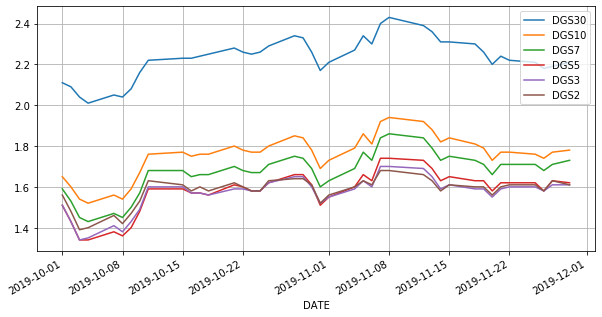

In [25]:
treasury_yield_df.plot(figsize=(10,5), grid=True)

In [26]:
gold_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily Return',
       'High minus low'],
      dtype='object')

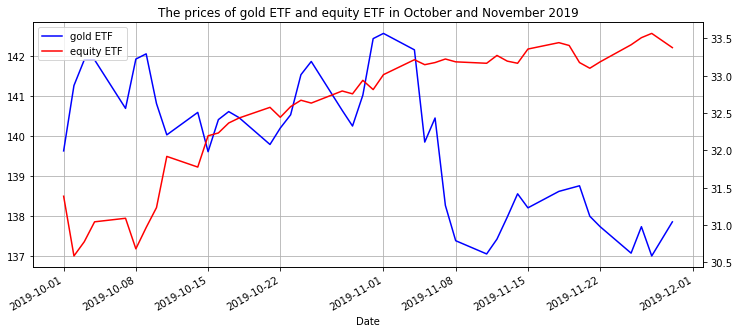

In [27]:
plt.figure(figsize=(12,5))
plt.title('The prices of gold ETF and equity ETF in October and November 2019')
ax1 = gold_df[gold_df.columns[-4]].plot(color='blue', grid=True, label='gold ETF')
ax2 = equity_df[equity_df.columns[-4]].plot(color='red', grid=True, secondary_y=True, label='equity ETF')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=0)
plt.show()

# 5. NSS fiting of yield curve

NelsonSiegelSvenssonCurve(beta0=1.6165739317650516, beta1=73503.92984126015, beta2=-73500.17056427168, beta3=-0.5347719102469805, tau1=0.1632533498710835, tau2=4.833973191651722)


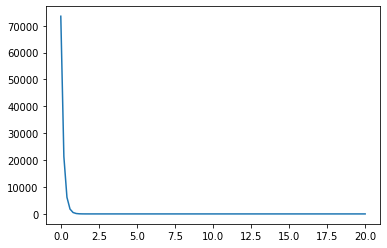

NelsonSiegelSvenssonCurve(beta0=1.6346478955532977, beta1=14524.252865772261, beta2=-14520.23394237897, beta3=-0.301803570436121, tau1=0.18646054012450547, tau2=4.817017231735168)


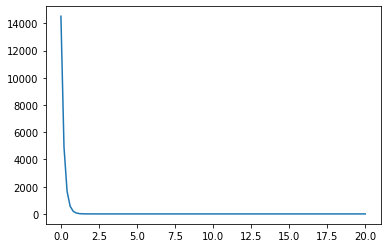

In [28]:
t =np.array([2.0,3.0,5.0,7.0,10.0,30.0])
#avarage yield rate for October 
y = np.array(oct_t_avg)

curve_fit, status = calibrate_nss_ols(t,y)
NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit,t)
NSS_ZC

Oct_curve, status = calibrate_nss_ols(t,NSS_ZC)
assert status.success
print(Oct_curve)

t = np.linspace(0,20,100)
plt.plot(t,Oct_curve(t))
plt.show()

#avarage yield rate for November 
t =np.array([2.0,3.0,5.0,7.0,10.0,30.0])
y = np.array(nov_t_avg)

curve_fit, status = calibrate_nss_ols(t,y)
NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit,t)
NSS_ZC

Nov_curve, status = calibrate_nss_ols(t,NSS_ZC)
assert status.success
print(Nov_curve)

t = np.linspace(0,20,100)
plt.plot(t,Nov_curve(t))
plt.show()

# 6. Modeling Prices

In [29]:
def get_data(df, month, column):
    return df[(df.index >= f"2019-{month:02d}-01") & (df.index < f"2019-{(month+1):02d}-01")][column]

In [30]:
def fit_arima(data):
    model = ARIMA(data, order=(3,0,3))
    model_fit = model.fit()
    print(model_fit.summary())
    residuals = pd.DataFrame(model_fit.resid)
    ax1 = residuals.plot(label='residual')
    plt.title("Residuals during the month")
    ax1.get_legend().remove()
    plt.show()
    ax2 = residuals.plot(kind='kde')
    plt.title("Kernel density estimation of the residuals")
    ax2.get_legend().remove()
    plt.show()

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
ARMA model for gold ETF in October


C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramete

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   23
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -21.992
Date:                Sun, 27 Jun 2021   AIC                             59.985
Time:                        18:17:24   BIC                             69.069
Sample:                    10-01-2019   HQIC                            62.269
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.8069      0.109   1288.998      0.000     140.593     141.021
ar.L1          0.1000      0.407      0.246      0.806      -0.698       0.898
ar.L2          0.4513      0.387      1.167      0.2

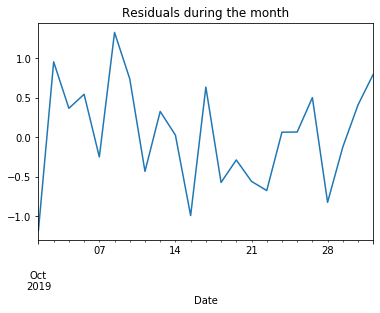

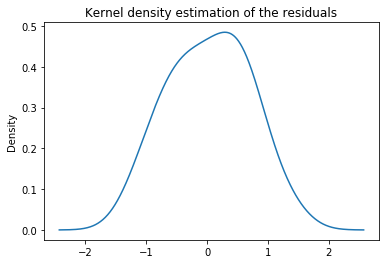

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
ARMA model for gold ETF in November


C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressi

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   20
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -22.205
Date:                Sun, 27 Jun 2021   AIC                             60.409
Time:                        18:17:25   BIC                             68.375
Sample:                             0   HQIC                            61.964
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.8121      0.870    159.626      0.000     137.108     140.517
ar.L1          0.7232      0.349      2.073      0.038       0.040       1.407
ar.L2          0.8180      0.465      1.760      0.0

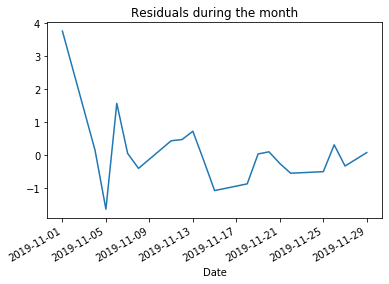

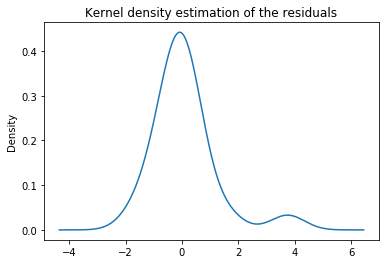

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
ARMA model for equity ETF in October


C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   23
Model:                 ARIMA(3, 0, 3)   Log Likelihood                  -2.339
Date:                Sun, 27 Jun 2021   AIC                             20.678
Time:                        18:17:26   BIC                             29.762
Sample:                    10-01-2019   HQIC                            22.963
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.0358      0.697     45.960      0.000      30.670      33.402
ar.L1         -0.4927      1.234     -0.399      0.690      -2.912       1.927
ar.L2          0.7715      0.285      2.703      0.0

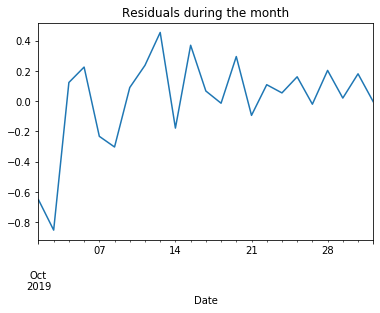

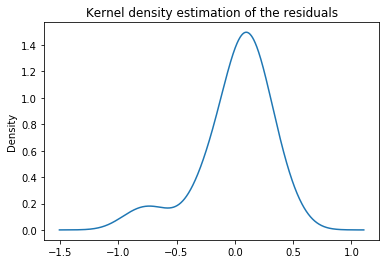

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
ARMA model for equity ETF in November


C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressi

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   20
Model:                 ARIMA(3, 0, 3)   Log Likelihood                  19.053
Date:                Sun, 27 Jun 2021   AIC                            -22.105
Time:                        18:17:28   BIC                            -14.139
Sample:                             0   HQIC                           -20.550
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2473      0.075    442.430      0.000      33.100      33.395
ar.L1          0.6105      0.684      0.893      0.372      -0.729       1.950
ar.L2          0.5045      0.862      0.585      0.5

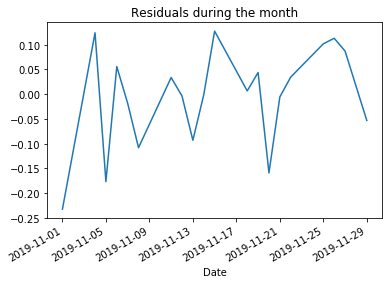

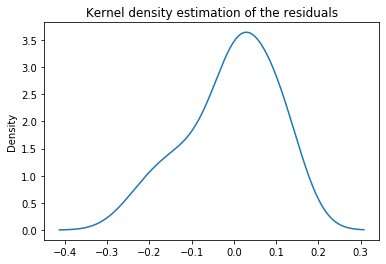

In [31]:
df_name = {0: "gold ETF", 1: "equity ETF"}
month_name = {10: "October", 11: "November"}
for index, df in enumerate([gold_df, equity_df]):
    for month in [10, 11]:
        print("-" * 78)
        print("-" * 78)
        print("-" * 78)
        print(f"ARMA model for {df_name[index]} in {month_name[month]}")
        data = get_data(df, month, "Adj Close")
        fit_arima(data)

# 7. Modeling volatility

In [32]:
def fit_garch(data):
    garch = arch.arch_model(data, vol='garch', p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())

In [33]:
for index, df in enumerate([gold_df, equity_df]):
    for month in [10, 11]:
        print("-" * 78)
        print("-" * 78)
        print("-" * 78)
        print(f"GARCH model for {df_name[index]} in {month_name[month]}")
        data = get_data(df, month, "Daily Return")
        data = data.dropna()
        fit_garch(data)

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
GARCH model for gold ETF in October
Iteration:      1,   Func. Count:      6,   Neg. LLF: -81.25706872359946
Iteration:      2,   Func. Count:     18,   Neg. LLF: -81.25762917608134
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -81.25762920838423
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                81.2576
Distribution:                  Normal   AIC:            

C:\anaconda\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\anaconda\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:

                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                73.9779
Distribution:                  Normal   AIC:                          -139.956
Method:            Maximum Likelihood   BIC:                          -135.973
                                        No. Observations:                   20
Date:                Sun, Jun 27 2021   Df Residuals:                       19
Time:                        18:17:29   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.4838e-03  7.497e-07  -1979.302     

C:\anaconda\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.371e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


# 8. Correlation

In [34]:
corr_oct = stats.pearsonr(gold_df[("2019-10-01" < gold_df.index) & (gold_df.index < "2019-11-01")]["Daily Return"], equity_df[("2019-10-01" < equity_df.index) & (equity_df.index < "2019-11-01")]["Daily Return"])[0]
print(f"The correlation of gold and equity ETFs in October is {corr_oct}")

The correlation of gold and equity ETFs in October is -0.6432166751736956


In [35]:
corr_nov = stats.pearsonr(gold_df[gold_df.index >= "2019-11-01"]["Daily Return"], equity_df[equity_df.index >= "2019-11-01"]["Daily Return"])[0]
print(f"The correlation of gold and equity ETFs in November is {corr_nov}")

The correlation of gold and equity ETFs in November is -0.07322047993786905


In [37]:
# new thing all together for arima
from pmdarima import auto_arima

step_fit=auto_arima(gold_df['Adj Close'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111.086, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113.080, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=113.080, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109.185, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=113.464, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.853 seconds


In [38]:
step_fit=auto_arima(equity_df['Adj Close'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2.055, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-0.914, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.091, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2.232, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=0.799, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.014 seconds
